### Загрузим основные пакеты

In [2]:
import scipy as sp
import scipy.linalg as spla
import scipy.optimize as spopt
import scipy.stats as spst

import numpy as np
import numpy.linalg as npla

import statsmodels as sm
import statsmodels.api as sma
smfOLS = sma.regression.linear_model.OLS.from_formula
smfLGT = sm.discrete.discrete_model.Logit.from_formula

import seaborn as sb
import pandas as pd

import matplotlib.pyplot as plt

from inspect import signature as sig

In [3]:
# matplotlib image size and resolution
mpl_options = {"figsize":(8,8), "dpi":100}
sb.set(rc={'figure.figsize':(12,8)})

### Вспомним наш ОЛС и предположим что истинная модель нелинейная: $y = sin(4 \pi x) +\varepsilon$

In [4]:
size = 1500

def create(size):
    x=np.random.uniform(size=size)
    # Не забудем центрировать !!!
    x=x-x.mean()
    eps=np.random.uniform(size=size)*2
    eps=eps-eps.mean()
    y = 3*np.sin(4*np.pi*x) + 3*eps
    return x, y

x, y = create(size)

<AxesSubplot:>

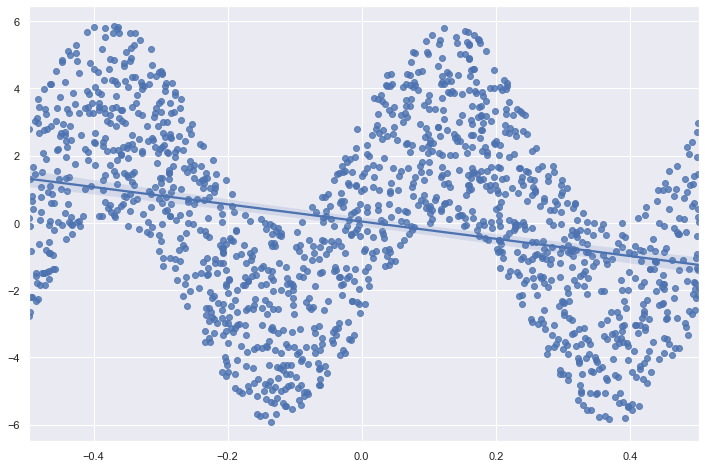

In [5]:
sb.regplot(x=x, y=y)

### Как это можно исправить?
- попробовать добавить больше степеней $х$ в регрессеию
- попробовать нелинейную регрессию (lowess)

# Поизучаем Lowess

<AxesSubplot:>

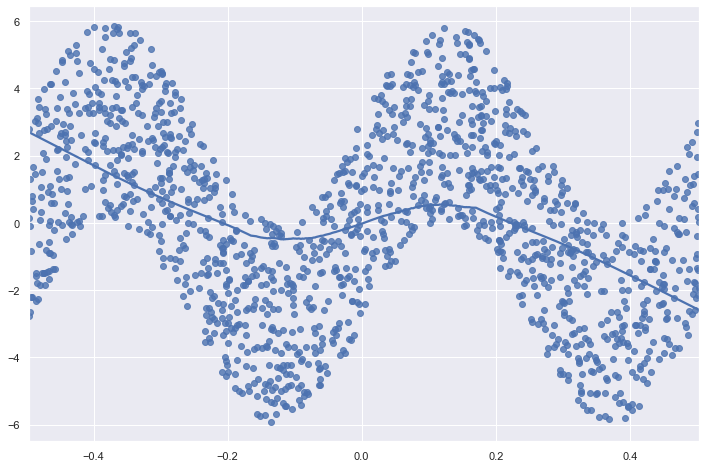

In [6]:
sb.regplot(x=x, y=y, lowess = True)

### Кажется, что можно улучшить фит, но как?
### Сиборн использует библиотеку statsmodels

In [13]:
from statsmodels.nonparametric.smoothers_lowess import lowess

frac = 0.7
fit =  lowess(y, x, frac= .1)
fit.shape

(1500, 2)

In [12]:
from inspect import signature
signature(lowess)

<Signature (endog, exog, frac=0.6666666666666666, it=3, delta=0.0, xvals=None, is_sorted=False, missing='drop', return_sorted=True)>

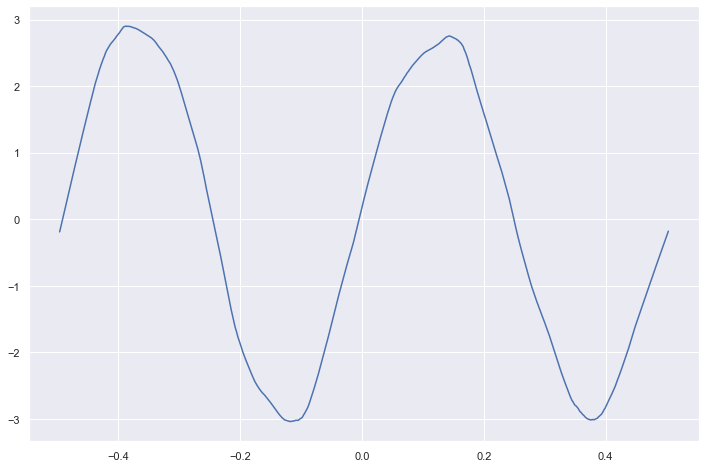

In [14]:
plt.plot(fit[:,0], fit[:,1])

### В ней есть параметр frac, управляющий качеством фита
### Вопрос на понимание, как выбрать параметр frac?

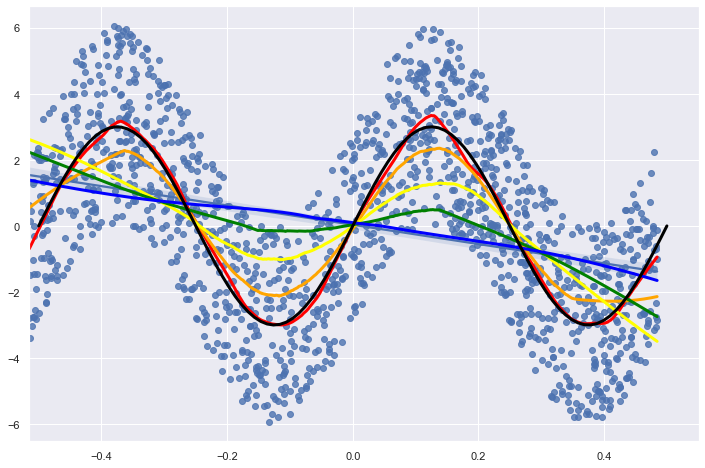

In [44]:
x, y = create(size)

sb.regplot(x=x, y=y)

fractions = [0.1,0.3,0.5,0.7,0.9]
colors = ['red', 'orange', 'yellow', 'green', 'blue']

for frac, color in zip(fractions, colors):
    fit = lowess(y, x, frac=frac)
    plt.plot(fit[:,0], fit[:,1], color = color, linewidth = 3)
    
xx = np.linspace(-.5,.5,100)
yy = 3*np.sin(4*np.pi*xx)
plt.plot(xx,yy, color = 'black', linewidth = 3)

### Как обычно трейдофф между фит и оверфит, так что надо кроссвалидировать

### Что такое вообще lowess? Это много маленьких взвешенных регрессий
$$ \min_{\beta} \sum w_i (y_i - x'_i \beta)^2 \quad \Rightarrow \quad \beta = (X'WX)^{-1}X'WY$$
где $W$ это диагональная матрица взвешивания, для OLS равная единичной $np.eye()$

веса обычно берут треугольные или что то типа $(1-d^3)^3\frac{70}{81}$ или $(1-d)\frac{3}{4}$ или $(1-d^2)\frac{15}{16}$

где $d$ это расстояние от точки которую оцениваем до точки которую взвешиваем

только $d$ должно лежать между $0$ и $1$ если $frac = 1$ или между $0$ и $frac$ в противном случае

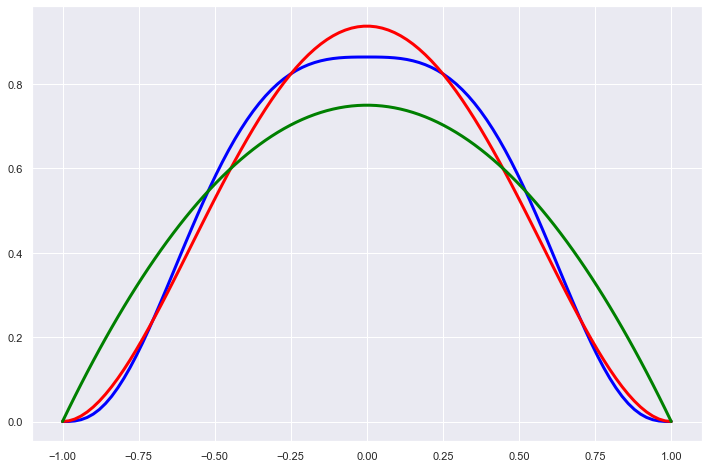

In [45]:
xxx = np.linspace(-1,1,100)
yyy1 = (1-np.abs(xxx*xxx*xxx))*(1-np.abs(xxx*xxx*xxx))*(1-np.abs(xxx*xxx*xxx))*70/81
yyy2 = (1-np.abs(xxx*xxx))*(1-np.abs(xxx*xxx))*15/16
yyy3 = (1-xxx*xxx)*3/4
plt.plot(xxx,yyy1, color = 'blue', linewidth = 3)
plt.plot(xxx,yyy2, color = 'red', linewidth = 3)
plt.plot(xxx,yyy3, color = 'green', linewidth = 3)

### Колоколобразные кривые с площадью 1, то есть плотности, это называется ядра

In [46]:
np.sum(yyy1), np.sum(yyy2), np.sum(yyy3)

(49.50000351557827, 49.499999484694925, 49.49494949494949)

### Тут площадь равна .5 почему то, но это неважно если выбирать окно через кроссвалидацию

### Попробуем составить этот эстиматор самостоятельно? Сначала в точке .2

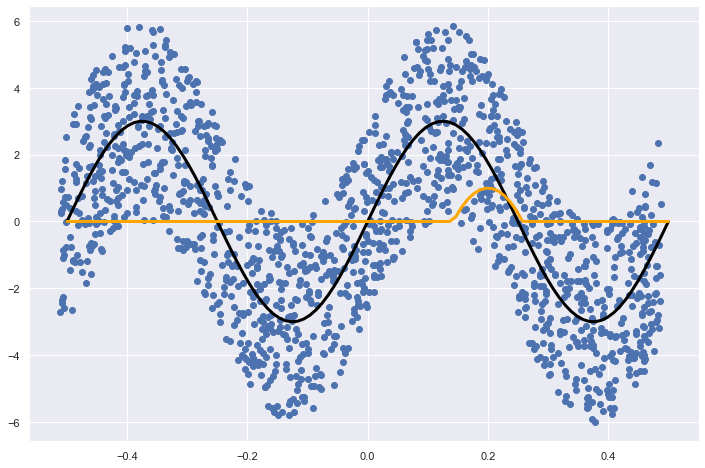

In [19]:
x, y = create(size)
plt.scatter(x, y)

xx = np.linspace(-.5,.5,100)
yy = 3*np.sin(4*np.pi*xx)
plt.plot(xx,yy, color = 'black', linewidth = 3)

locus = .2
scale = 300

def kernel(z):
    return np.clip((1-scale*(z-locus)*(z-locus)),0,1)

xx = np.linspace(-.5,.5,100)
yy = np.fromiter(map(lambda z: kernel(z), xx), dtype=float)
plt.plot(xx, yy, color = 'orange', linewidth = 3)

In [20]:
import statsmodels.tools.tools as tools

In [21]:
x, y = create(size)
x = tools.add_constant(x)

In [22]:
weights = np.fromiter(map(kernel, x[:,1]), dtype=float)
weights

array([0., 0., 0., ..., 0., 0., 0.])

In [51]:
def loss(Y, X, beta):
    z = weights*(Y - X@beta)
    return z@z.T

In [52]:
loss(y, x, [1,2])

332.082307446159

In [62]:
bounds = [(-100, 100)]*2
fit = spopt.shgo(lambda b: loss(y, x, b), bounds)
fit

     fun: 262.71102110527875
    funl: array([262.71102111])
 message: 'Optimization terminated successfully.'
    nfev: 28
     nit: 2
   nlfev: 23
   nlhev: 0
   nljev: 6
 success: True
       x: array([  8.24365172, -32.08317579])
      xl: array([[  8.24365172, -32.08317579]])

In [63]:
fit2 = lowess(y, x[:,1], frac=.1)
#plt.plot(fit[:,0], fit[:,1], color = color, linewidth = 3)

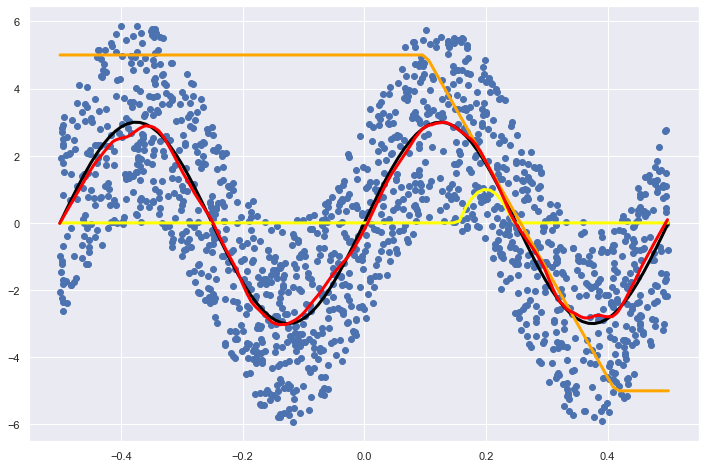

In [64]:
plt.scatter(x[:,1], y)

xx = np.linspace(-.5,.5,100)
yy = 3*np.sin(4*np.pi*xx)
plt.plot(xx,yy, color = 'black', linewidth = 3)

locus = .2
scale = 500

xx = np.linspace(-.5,.5,100)
yy = np.fromiter(map(lambda z: kernel(z), xx), dtype=float)
plt.plot(xx, yy, color = 'yellow', linewidth = 3)

plt.plot(xx, np.clip(fit.x[0]+xx*(fit.x[1]),-5,5), color = 'orange', linewidth = 3)
plt.plot(fit2[:,0], fit2[:,1], color = 'red', linewidth = 3)

### Только теперь надо в каждой точке отдельно сосчитать. Вообще, это довольно сложный алгоритм, его многофакторное обобщение называется LOESS (а не LOWESS) и они лучшее реализованы в R чем в питоне